In [15]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask, smaller_dtypes
import utils

from yahist import Hist1D, Hist2D

import concurrent.futures

import scipy.stats
from dask.distributed import Client
import dask.dataframe as dd
from dask import delayed

In [16]:
set_plotting_style()

In [44]:
executor = concurrent.futures.ProcessPoolExecutor(8)

def make_df(fname,entrystart=None,entrystop=None):
    try:
        t = uproot.open(fname)["Events"]
        arrs = t.arrays(["pass_*",
                         "dimuon_*","logabsetaphi",
                         "DV_rhoCorr",
#                          "/BS_(x|y|z)$/",
#                          "/Muon_n(Valid|Matched|Tracker|Expected).*/",
#                          "/Muon_(pt|eta|phi|m|trackIso|charge|dz.*|dxy.*|chi2|ndof|drjet|pass*)$/",
#                          "/DV_(chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError|pass*)$/",
#                          "run","luminosityBlock","event",
#                          "dimuon_*","cosphi*","absdphi*","minabs*","logabs*",#"lxy",
#                          "L1_*",
                        ],outputtype=dict,namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    except:
        print(f"Error reading ({fname},{entrystart},{entrystop})")
        return pd.DataFrame()
        
    
    # booleans for selection
    sel = arrs["pass_baseline_iso"]

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi","event","L1_",
                                        "dimuon","cosphi","absdphi","minabs","logabs","lxy"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]

    for name,dtype in smaller_dtypes:
        if name not in df.columns: continue
        df[name] = df[name].astype(dtype, copy=False)
    return df

fnames_mc = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd2_ctau25mm_BABY_v10//output_1.root")
fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v9_unblind1fb_RAW_v10/*.root")

futures = [executor.submit(make_df,fname) for fname in fnames_data[:60]]
df_data = pd.concat([f.result() for f in tqdm(futures)])
df_mc = pd.concat([make_df(fname) for fname in tqdm(fnames_mc)])

del executor

In [45]:
df_data

,pass_skim,pass_l1,pass_fiducialgen,pass_fiducialgen_norho,pass_baseline,pass_baseline_iso,dimuon_isos,dimuon_pt,dimuon_eta,dimuon_phi,dimuon_mass,logabsetaphi,DV_rhoCorr
0,True,True,True,True,True,True,True,6.785450,-1.719587,-1.509560,3.521773,-0.335063,0.276482
1,True,True,True,True,True,True,True,9.995001,-2.200407,-1.498460,2.357998,-0.178866,0.400203
2,True,True,True,True,True,True,True,13.403290,-0.181438,1.970171,3.328078,0.043328,0.154702
3,True,True,True,True,True,True,True,19.872871,-1.057557,-1.488785,2.767724,0.252955,0.178108
4,True,True,True,True,True,True,True,12.496560,-0.537675,1.118723,1.328601,0.696239,1.013924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18390,True,True,True,True,True,True,True,10.734475,0.390747,-2.396806,3.035287,-0.557728,0.012540
18391,True,True,True,True,True,True,True,47.984219,1.290620,-2.473013,2.318833,-1.063197,1.618355
18392,True,True,True,True,True,True,True,11.462634,-2.122771,1.109399,3.385293,-0.365356,0.094992
18393,True,True,True,True,True,True,True,32.439503,-1.661048,1.546489,1.473840,-0.013453,0.586006


In [46]:
# # make_df(fnames_mc[0])
# # fnames_data
# df_mc = pd.concat([make_df(fname) for fname in tqdm(fnames_mc)])
# df_data = pd.concat([make_df(fname) for fname in tqdm(fnames_data[:10])])

In [47]:
print(df_mc.shape)
print(df_data.shape)

(1559, 13)
(1199989, 13)


Text(0, 0.5, 'frac. of events')

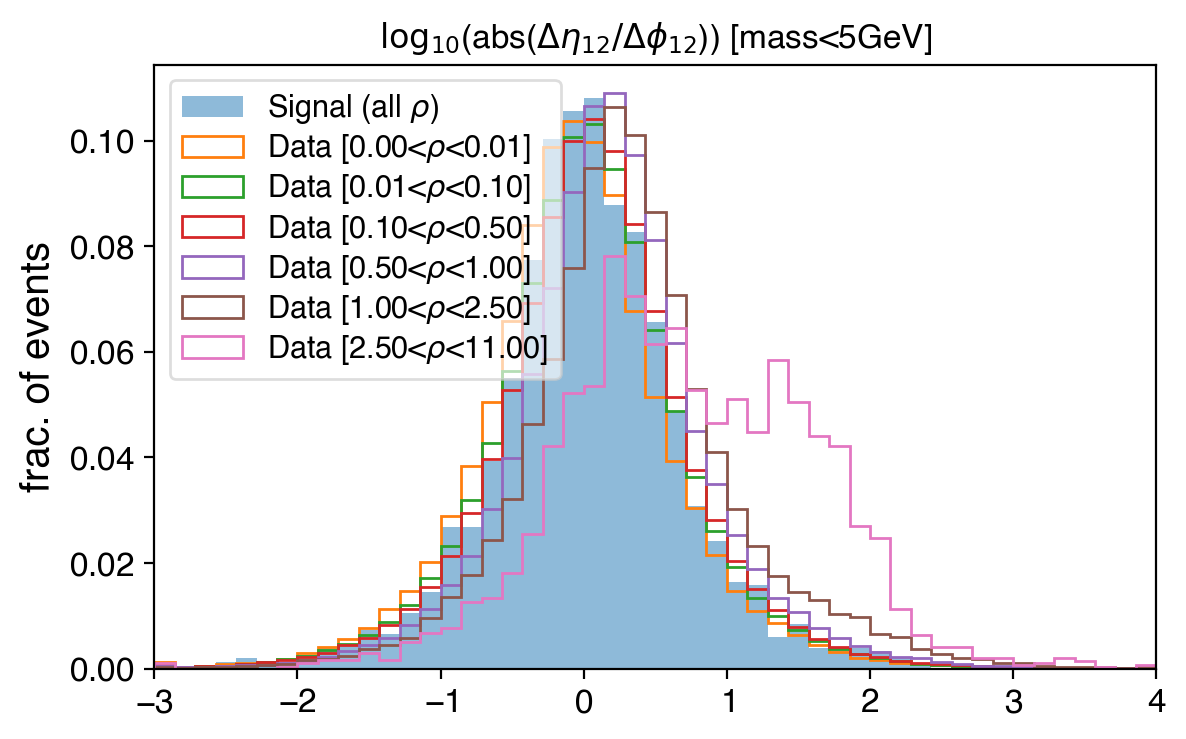

In [53]:
fig, ax = plt.subplots()
bins = np.linspace(-3,4,50)
varexp = "logabsetaphi"
rhos = np.array([0,0.01,0.1,0.5,1.0,2.5,11.])
globalsel = "(dimuon_mass<5) and pass_baseline_iso"

h = df_mc.tree.draw(varexp,globalsel,bins=bins)
h = h.normalize()
h.plot(ax=ax,label=r"Signal (all $\rho$)",histtype="stepfilled",alpha=0.5)
# cmap = matplotlib.cm.get_cmap('Reds')
# colors = cmap(np.linspace(0.3,0.9,len(rhos)-1))

# for color,low,high in zip(colors,rhos[:-1],rhos[1:]):
for low,high in zip(rhos[:-1],rhos[1:]):
    sel = f"{globalsel} and ({low}<DV_rhoCorr<{high})"
    h = df_data.tree.draw(varexp,sel,bins=bins)
    h = h.normalize()
    label = rf"Data [{low:.2f}<$\rho$<{high:.2f}]"
    h.plot(ax=ax,label=label,histtype="step") #,color=color)
    
ax.set_title(r"$\log_{10}$(abs($\Delta\eta_{12}/\Delta\phi_{12}$)) [mass<5GeV]")
ax.legend(loc="upper left")
ax.set_ylabel("frac. of events")

In [57]:
1e-6*df_data.memory_usage().sum()

46.799571

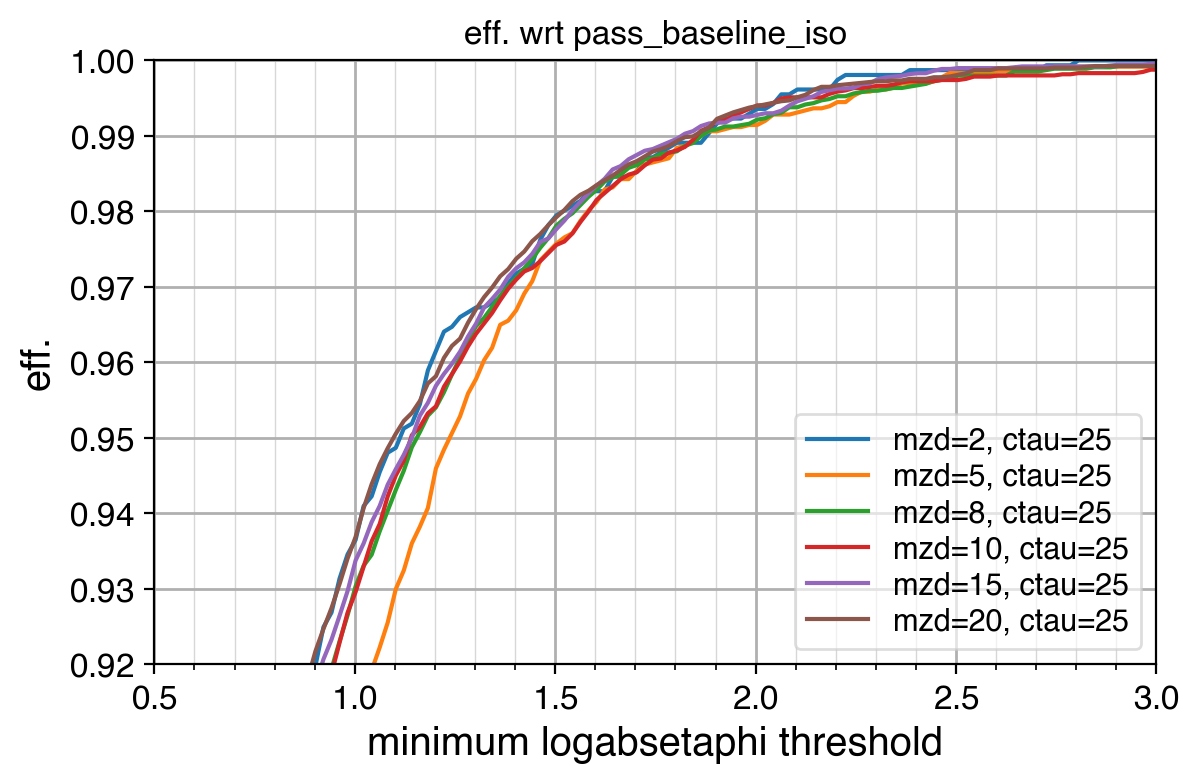

In [10]:
fig, ax = plt.subplots()

fnames = sorted(
    glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd*_ctau*mm_BABY_v10/output_1.root"),
    key=lambda x:(int(x.split("_mzd")[1].split("_")[0]),int(x.split("_ctau")[1].split("mm")[0])),
)

dfs = []
for fname in tqdm(fnames):
    mzd = int(fname.split("_mzd")[1].split("_")[0])
    ctau = int(fname.split("_ctau")[1].split("mm")[0])
#     if mzd not in [8]: continue
    if ctau not in [25]: continue
#     if mzd not in [2,8]: continue
    t = uproot.open(fname)["Events"]

    # t = uproot.open("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v10/output_1.root")["Events"]
#     fname = "/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd2_ctau50mm_BABY_v10/output_1.root"
    t = uproot.open(fname)["Events"]
    vals = t["logabsetaphi"].array()[t["pass_baseline_iso"].array()]
    h = Hist1D(vals,bins=np.linspace(-5,5,500))
    ax.plot(
        h.bin_centers,
        h.counts.cumsum()/h.counts.sum(),
        label=f"mzd={mzd}, ctau={ctau}",
    )
ax.set_xlim([0.5,3])
ax.set_ylim([0.92,1.0])
ax.set_xlabel("minimum logabsetaphi threshold")
ax.set_ylabel("eff.")
ax.set_title("eff. wrt pass_baseline_iso")
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which="major",lw=1)
ax.grid(which="minor",alpha=0.5, lw=0.5)
ax.legend()